In [17]:
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import iris
import iris.plot as iplt
import iris.quickplot as qplt
import datetime
from iris.time import PartialDateTime
from iris.util import mask_cube_from_shapefile
import cartopy.io.shapereader as shpreader
from shapely.ops import unary_union
from shapely.geometry.polygon import Polygon
from shapely import MultiPolygon, Polygon

import os
import torch
import pandas as pd
import sklearn
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.autograd import Variable 
from torch.utils.data import DataLoader, TensorDataset

from sklearn.preprocessing import StandardScaler, MinMaxScaler


In [18]:
filenames = ['C:/Users/Tilt/Downloads/Project/Data/data_2010.nc','C:/Users/Tilt/Downloads/Project/Data/data_2011.nc',
             'C:/Users/Tilt/Downloads/Project/Data/data_2012.nc','C:/Users/Tilt/Downloads/Project/Data/data_2013.nc',
             'C:/Users/Tilt/Downloads/Project/Data/data_2014.nc','C:/Users/Tilt/Downloads/Project/Data/data_2015.nc',
             'C:/Users/Tilt/Downloads/Project/Data/data_2016.nc','C:/Users/Tilt/Downloads/Project/Data/data_2017.nc',
             'C:/Users/Tilt/Downloads/Project/Data/data_2018.nc','C:/Users/Tilt/Downloads/Project/Data/data_2019.nc']
cubes = iris.load(filenames)
cubes = cubes.concatenate()
#print(cubes)

In [19]:
ConstraintNames = [
    'burned_area',
    'population_density',
    '10 metre wind speed',
    '2 metre temperature',
    'Convective available potential energy',
    'Leaf area index, high vegetation',
    'Leaf area index, low vegetation',
    'Total precipitation',
    'Volumetric soil water layer 1',
    'observed_fraction_mask',
    'standard error of the estimation of burned area'
]

cubesList = { name: cubes.extract(iris.Constraint(name))[0] for name in ConstraintNames}
print(cubesList)

{'burned_area': <iris 'Cube' of burned_area / (m2) (time: 120; latitude: 720; longitude: 1440)>, 'population_density': <iris 'Cube' of population_density / (unknown) (time: 120; latitude: 720; longitude: 1440)>, '10 metre wind speed': <iris 'Cube' of 10 metre wind speed / (m s**-1) (time: 120; latitude: 720; longitude: 1440)>, '2 metre temperature': <iris 'Cube' of 2 metre temperature / (K) (time: 120; latitude: 720; longitude: 1440)>, 'Convective available potential energy': <iris 'Cube' of Convective available potential energy / (J kg**-1) (time: 120; latitude: 720; longitude: 1440)>, 'Leaf area index, high vegetation': <iris 'Cube' of Leaf area index, high vegetation / (m**2 m**-2) (time: 120; latitude: 720; longitude: 1440)>, 'Leaf area index, low vegetation': <iris 'Cube' of Leaf area index, low vegetation / (m**2 m**-2) (time: 120; latitude: 720; longitude: 1440)>, 'Total precipitation': <iris 'Cube' of Total precipitation / (m) (time: 120; latitude: 720; longitude: 1440)>, 'Volu

In [20]:
CountryName = "Portugal"

country_shp_reader = shpreader.Reader(
    shpreader.natural_earth(
        resolution="110m", category="cultural", name="admin_0_countries"
    )
)
Country_shp = [
    country.geometry
    for country in country_shp_reader.records()
    if CountryName in country.attributes["NAME_LONG"]
][0]
ObsMaskCube = mask_cube_from_shapefile(cubesList["observed_fraction_mask"], Country_shp)
ObsMaskCube = iris.analysis.maths.log(ObsMaskCube)
ObsMaskCube = iris.analysis.maths.exp(ObsMaskCube)

b=0
a = ObsMaskCube.data
print("Verification - Count should Equal Sum")
print("Count =",ma.count(a))
print("Sum =",np.sum(a))
if(np.round(np.sum(a)) == ma.count(a)):
    b=b+1
print("Verification Mean should = 1")
print("Mean = ",np.mean(a))
if(np.round(np.mean(a)) == 1):
    b=b+1
print("We have",ma.count(a),"Datapoints Per Month")
if(b==2):
    print("All Verified - Continue")
else:
    print("Somethings gone wrong.")

BurnedCube = iris.analysis.maths.multiply(cubesList["burned_area"], ObsMaskCube)
PopnCube = iris.analysis.maths.multiply(cubesList["population_density"], ObsMaskCube)
WindCube = iris.analysis.maths.multiply(cubesList["10 metre wind speed"], ObsMaskCube)
TempCube = iris.analysis.maths.multiply(cubesList["2 metre temperature"], ObsMaskCube)
CAPECube = iris.analysis.maths.multiply(cubesList["Convective available potential energy"], ObsMaskCube)
HVegCube = iris.analysis.maths.multiply(cubesList["Leaf area index, high vegetation"], ObsMaskCube)
LVegCube = iris.analysis.maths.multiply(cubesList["Leaf area index, low vegetation"], ObsMaskCube)
PrecipCube = iris.analysis.maths.multiply(cubesList["Total precipitation"], ObsMaskCube)
SoilCube = iris.analysis.maths.multiply(cubesList["Volumetric soil water layer 1"], ObsMaskCube)

c:\Users\Tilt\miniconda3\Lib\site-packages\iris\_shapefiles.py:147: IrisDefaultingWarning: Cube has no coord_system; using default GeogCS lat/lon
  warnings.warn(


c:\Users\Tilt\miniconda3\Lib\site-packages\dask\core.py:127: RuntimeWarning: divide by zero encountered in log
  return func(*(_execute_task(a, cache) for a in args))


Verification - Count should Equal Sum
Count = 173
Sum = 173.0
Verification Mean should = 1
Mean =  1.0
We have 173 Datapoints Per Month
All Verified - Continue


(120, 720, 1440)
[0.0 0.0 0.0 ... 0.0 0.0 0.0]
20760
173


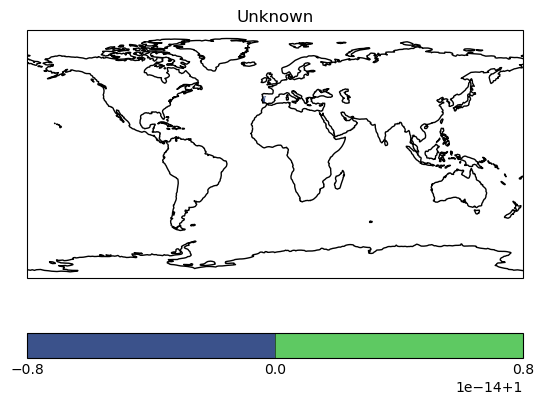

In [21]:
a = BurnedCube.data
print(np.shape(a))
aNoMask = a[~a.mask]
print(aNoMask)
print(len(aNoMask))

aMonth = BurnedCube[0].data
aNoMaskMonth = aMonth[~aMonth.mask]
print(len(aNoMaskMonth))
# 173 Datapoints Per for Portugal
Timesteps = round(len(aNoMask)/len(aNoMaskMonth))
Samples = len(aNoMaskMonth)

qplt.contourf(ObsMaskCube, 25)
plt.gca().coastlines()
plt.show()

In [22]:
def DeCube(InCube):
    InCube = InCube.data
    InCube = InCube[~InCube.mask]
    InCube = InCube.reshape(Timesteps, Samples)
    return InCube

In [23]:
#Verifying this doesnt break it
#a = BurnedCube.data
#a = a[~a.mask]
#print(len(a))

Burned = DeCube(BurnedCube)

Popn = DeCube(PopnCube)
Wind = DeCube(WindCube)
Temp = DeCube(TempCube)
CAPE = DeCube(CAPECube)
HVeg = DeCube(HVegCube)
LVeg = DeCube(LVegCube)
Precip = DeCube(PrecipCube)
Soil = DeCube(SoilCube)

Popn = np.log(Popn)

scaler = MinMaxScaler()
scaler.fit(Popn)
Popn = scaler.transform(Popn) 
scaler.fit(Wind)
Wind = scaler.transform(Wind) 
scaler.fit(Temp)
Temp = scaler.transform(Temp) 
scaler.fit(CAPE)
CAPE = scaler.transform(CAPE) 
scaler.fit(HVeg)
HVeg = scaler.transform(HVeg) 
scaler.fit(LVeg)
LVeg = scaler.transform(LVeg) 
scaler.fit(Precip)
Precip = scaler.transform(Precip) 
scaler.fit(Soil)
Soil = scaler.transform(Soil) 

print("Num WildFires = ", len(Burned[Burned>0]))

X_full = np.dstack((Popn,Wind,Temp,CAPE,HVeg,LVeg,Precip,Soil,Burned))
print(X_full.shape)
X_full = X_full.reshape(-1, X_full.shape[-1])
print(X_full.shape)
X_fullNonZero = X_full[X_full[:,8]>0]
print(X_fullNonZero.shape)

y_fullNonZero = X_fullNonZero[:,-1]
X_fullNonZero = X_fullNonZero[:,0:8]

NumNonZero = X_fullNonZero.shape[0]

y_fullNonZero = np.log2(y_fullNonZero)
y_fullNonZero = y_fullNonZero.reshape(NumNonZero,1)

#print(X_fullNonZero)
#print(y_fullNonZero)

np.random.seed(42)
sample = np.random.choice([True, True, True, True, False], (NumNonZero, 1))
print(sample.shape)
X_fullNonZeroTrain = X_fullNonZero * sample
X_fullNonZeroTest = X_fullNonZero * (1-sample)
#print(X_fullNonZeroTrain)

y_train = y_fullNonZero * sample
y_test = y_fullNonZero * (1-sample)
X_fullNonZeroTrain = X_fullNonZeroTrain[~np.all(X_fullNonZeroTrain == 0, axis=1)]
X_fullNonZeroTest = X_fullNonZeroTest[~np.all(X_fullNonZeroTest == 0, axis=1)]
y_train = y_train[~np.all(y_train == 0, axis=1)]
y_test = y_test[~np.all(y_test == 0, axis=1)]

X_train = X_fullNonZeroTrain
X_test = X_fullNonZeroTest

#scalerY = MinMaxScaler()
#scalerY.fit(y_train)
#y_train = scalerY.transform(y_train) 
#y_test = scalerY.transform(y_test) 

print("Training Shape",X_train.shape,y_train.shape)
print("Testing Shape",X_test.shape,y_test.shape)

Num WildFires =  1500
(120, 173, 9)
(20760, 9)
(1500, 9)
(1500, 1)
Training Shape (1189, 8) (1189, 1)
Testing Shape (311, 8) (311, 1)


In [24]:
from sklearn.svm import SVR
regressor = SVR(kernel = 'rbf',degree=15,gamma=0.5,C=0.5)
regressor.fit(X_train, y_train.ravel())
y_pred = regressor.predict(X_test)
print(y_pred.shape)
print(y_test.ravel().shape)
Delta = y_test.ravel() - y_pred
print(Delta.mean())

(311,)
(311,)
0.3464757190015294


In [25]:
y_predUnsc = y_pred#scalerY.inverse_transform(y_pred.reshape(-1, 1))
y_testUnsc = y_test#scalerY.inverse_transform(y_test)

#print(y_predUnsc.mean())
#print(y_testUnsc.mean())
DeltaUnsc = y_predUnsc - y_testUnsc
#print(DeltaUnsc.mean())

y_predReal = 2**(y_predUnsc)
y_testReal = 2**(y_testUnsc)

DeltaReal = y_predReal - y_testReal
DeltaReal = abs(DeltaReal)
Perc = (np.abs(DeltaReal)/y_testReal)
#print(Perc.mean())
#print(y_predReal.mean())
#print(y_testReal.mean())
#print(DeltaReal.mean())

In [26]:
SECube = iris.analysis.maths.multiply(cubesList['standard error of the estimation of burned area'], ObsMaskCube)
SE = DeCube(SECube)
SE = SE.reshape(-1)
#print(SE.shape)
SE = SE[X_full[:,8]>0]
SE = SE.reshape(NumNonZero,1)
SEtest = SE * (1-sample)
SEtest = SEtest[~np.all(SEtest == 0, axis=1)]
#print(SEtest.shape)
#print(DeltaReal.shape)
CompColV = np.hstack((SEtest,DeltaReal))
IsVAccurateCol = np.zeros((y_pred.shape[0],1))
#print(IsVAccurateCol.shape[0])
for i in range(IsVAccurateCol.shape[0]):
    if CompColV[i,1] > CompColV[i,0]:
        IsVAccurateCol[i,0] = 0
    else:
        IsVAccurateCol[i,0] = 1
print("Percentage of Predictions within 1*SE of Burned Area =",IsVAccurateCol.mean())
CompCol = np.hstack((2*SEtest,DeltaReal))
IsAccurateCol = np.zeros((y_pred.shape[0],1))
#print(IsAccurateCol.shape[0])
for i in range(IsAccurateCol.shape[0]):
    if CompCol[i,1] > CompCol[i,0]:
        IsAccurateCol[i,0] = 0
    else:
        IsAccurateCol[i,0] = 1
print("Percentage of Predictions within 2*SE of Burned Area =",IsAccurateCol.mean())
CompColNR = np.hstack((3*SEtest,DeltaReal))
IsNRAccurateCol = np.zeros((y_pred.shape[0],1))
#print(IsVAccurateCol.shape[0])
for i in range(IsNRAccurateCol.shape[0]):
    if CompColNR[i,1] > CompColNR[i,0]:
        IsNRAccurateCol[i,0] = 0
    else:
        IsNRAccurateCol[i,0] = 1
print("Percentage of Predictions within 3*SE of Burned Area =",IsNRAccurateCol.mean())

Percentage of Predictions within 1*SE of Burned Area = 0.28938906752411575
Percentage of Predictions within 2*SE of Burned Area = 0.4758842443729904
Percentage of Predictions within 3*SE of Burned Area = 0.5691318327974276


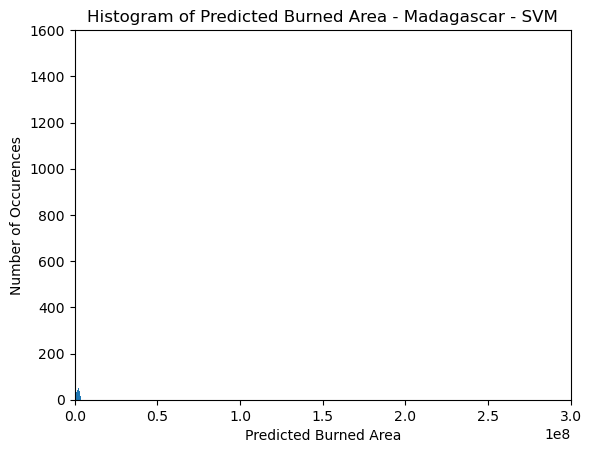

In [27]:
plt.hist(y_predReal, bins=8)
plt.axis([0, 300000000,0,1600])
plt.title("Histogram of Predicted Burned Area - Madagascar - SVM")
plt.xlabel("Predicted Burned Area")
plt.ylabel("Number of Occurences")
plt.show()

Delta = ~1/3

Same as Linear, more reproducible tho